In [1]:
from google.colab import drive
drive.mount('/content/drive')
from importlib import reload  # Py3 only; unneeded in py2.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/My Drive/FuelProject/data'

/content/drive/My Drive/FuelProject/data


In [3]:
!pip3 install eli5
!pip3 install pdpbox

In [0]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from eli5.sklearn import PermutationImportance
from sklearn.metrics import mean_squared_error
from pdpbox import pdp, get_dataset, info_plots
from sklearn.feature_selection import f_regression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [0]:
def compr(list_it,remove_it):
  return [x for x in list_it if x not in remove_it]

def ppl_to_df(ppl,name,X,y,fit=True):
  if(fit):
    trans=ppl.fit_transform(X,y)
  else:
    trans=ppl.transform(X)
  ndf = pd.DataFrame(trans,columns=ppl[name].get_feature_names()).astype("float")
  return ndf.rename(columns=lambda x: re.findall("\_\_(.*)\Z",x)[0])

def feat_importance(m, df,plot=False,top=10):
    imp_df = pd.DataFrame({'cols':df.columns, 'imp':m}
                       ).sort_values('imp', ascending=False)
    if(plot):
      fig, axbo = plt.subplots(1, 1, figsize=(10, 6))
      sns.barplot(x="cols",y="imp",data=imp_df[:top],palette="Blues_d",ax=axbo)
      plt.show()
    return imp_df.set_index("cols")

class DoNothing(BaseEstimator, TransformerMixin):
    def __init__(self):
      pass
    def fit(self,x=None,y=None):
      self.params = x.columns
      return self
    def transform(self,x=None):
      return x
    def get_feature_names(self):
      return list(self.params)

class MintoMean(BaseEstimator, TransformerMixin):
    def __init__(self,miss):
      self.miss = miss
      self.minv={}
      self.mean={}
    def fit(self,x=None,y=None):
      self.params = x.columns
      self.minv=x.apply(lambda cval:cval.min(),axis=0)+self.miss
      self.mean=x.apply(lambda cval:cval[cval>cval.min()].mean(),axis=0)
      return self
    def transform(self,x=None):
      for col in x.columns:
        x[col+"_out"]=(x[col]<self.minv[col])
        x[col].where(x[col]>self.minv[col],other=self.mean[col],inplace=True)
      self.params = x.columns
      return x
    def get_feature_names(self):
      return list(self.params)

class CorrCount:

  def __init__(self,dataset,coeff):
    correlation = dataset.corr()
    correlation.dropna(axis=0,how="all",inplace=True)
    correlation.dropna(axis=1,how="all",inplace=True)
    
    col1=pd.Series(correlation.index).repeat(correlation.iloc[0].size).reset_index()
    col2=pd.concat([pd.Series(correlation.index)]*correlation.iloc[0].size).reset_index()
    col3=pd.Series(np.squeeze(correlation.values.reshape(-1,1))).reset_index()
    
    corrtab=pd.DataFrame({"col1":col1[0],"col2":col2[0],"coef":col3[0]})
    corrtab=corrtab[corrtab["col1"]!=corrtab["col2"]]

    self.correlation = correlation
    self.highcorrtab = corrtab[((corrtab["coef"]>coeff)|(corrtab["coef"]<coeff*-1))]

  def betterval(self,impor,feat_X):

    def to_remove(feat,imortance):
      if((imortance.loc[feat["col1"]]<imortance.loc[feat["col2"]]).bool()):
        return feat["col1"]
      else:
        return False

    rem = self.highcorrtab.apply(lambda x:to_remove(x,impor),axis=1).unique()
    rem = rem[rem!=False]
    return feat_X.drop(columns=rem)






In [0]:
test1 = pd.read_csv("Test_ex.csv")

In [0]:
traine = pd.read_csv("train_unstruc.csv")

In [0]:
test1.drop(columns=["id"],inplace=True)
test1=test1.astype("float")

In [0]:
traine.rename(columns=dict(zip(traine.columns,test1.columns)),inplace=True)

In [0]:
traine=traine[traine["Year"]!='Year']
traine=traine.astype("float")
z_cols=traine.columns[traine.var()==0]
traine.drop(columns=z_cols,inplace=True)

In [0]:
train["Year"].unique()

In [0]:
test_sam=test1.sample(50000)
train_sam=train.sample(50000)

In [0]:
test_sam.drop(columns=["FF"],inplace=True)
train_sam.drop(columns=["FF"],inplace=True)
test_sam["Predictor"]=0
train_sam["Predictor"]=1

In [0]:
search_df = test_sam.append(train_sam)

In [0]:
split_model = RandomForestClassifier(n_estimators=75)

In [0]:
split_model.fit(search_df.drop(columns=["Predictor"]),search_df["Predictor"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=75,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
train=pd.DataFrame(train,columns=test1.columns)

In [0]:
rf_feat_importance(split_model,search_df.drop(columns=["Predictor"]))[:10]

,cols,imp
2,Year,0.177910
1,Flight_instance_ID,0.161910
57,SPL_2,0.088977
82,CWPF_Mean,0.061986
74,CCPC_Min,0.051332
75,CCPC_Max,0.045541
84,CWPF_Max,0.043654
83,CWPF_Min,0.041320
48,PTRM,0.032509
208,ACMT,0.029541


In [0]:
validate=traine.sort_values(by=["Year","Month"])[:50000]
validate_X = validate.drop(columns="FF")
validate_y = validate["FF"]
rest1=traine.sort_values(by=["Year","Month"])[50000:]
fligth_ids = validate["Flight_instance_ID"].unique()

In [0]:
test=rest1[~rest1["Flight_instance_ID"].isin(fligth_ids)][:50000]
test_X = test.drop(columns="FF")
test_y = test["FF"]
rest2=rest1[~rest1["Flight_instance_ID"].isin(fligth_ids)][50000:]
fligth_ids = test["Flight_instance_ID"].unique()

In [0]:
train=rest2[~rest2["Flight_instance_ID"].isin(fligth_ids)]

train=train.sample(350000)
train_X = train.drop(columns="FF")
train_y = train["FF"]

In [0]:
featcorr = CorrCount(train_X,0.9)

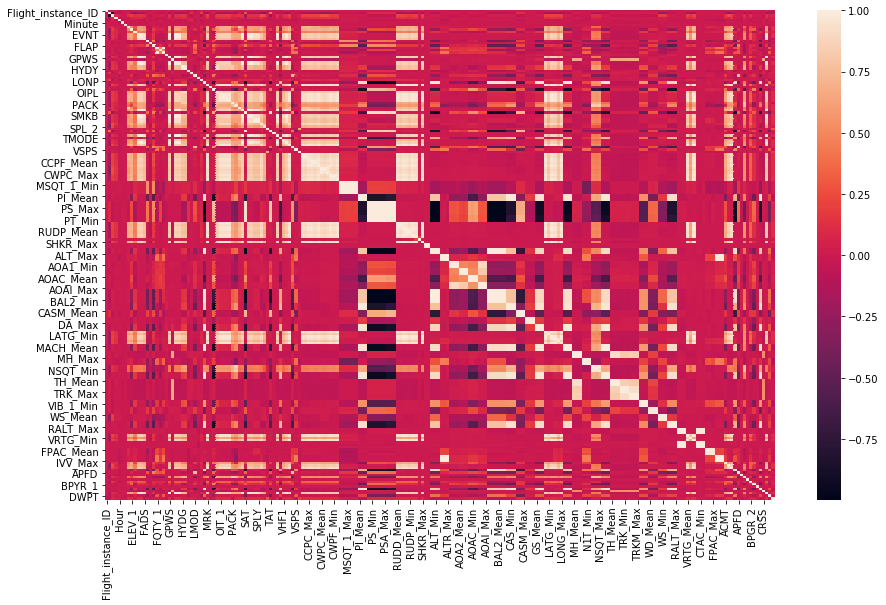

In [15]:
fig, axbo = plt.subplots(1, 1, figsize=(15, 9))
sns.heatmap(featcorr.correlation,ax=axbo)
plt.show()

PH analys

In [0]:
phticks=["Unknown","Preflight","Taxi","Takeoff","Climb","Cruise","Approuch","Rollout"]

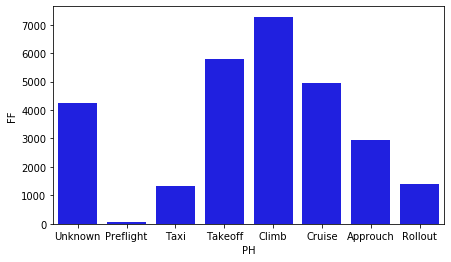

In [17]:
phan=pd.DataFrame(train.groupby("PH").mean()["FF"])
fig, axbo = plt.subplots(1, 1, figsize=(7, 4))
sns.barplot(x=phan.index,y="FF",data=phan,color="blue",ax=axbo)
axbo.set_xticklabels(phticks)
plt.show()

# First model

In [0]:
mask=np.concatenate([np.zeros(300000),np.ones(50000)]).astype("bool")
np.random.shuffle(mask)

In [19]:
pre_mod=RandomForestRegressor(n_estimators=25,min_samples_leaf=40,max_features=100)
pre_mod.fit(train_X[mask],train_y[mask])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=100, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=40,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=25, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [20]:
mean_squared_error(test_y,[train_y.mean()]*50000)
mean_squared_error(test_y,pre_mod.predict(test_X))

63502.73790671786

# Important Features

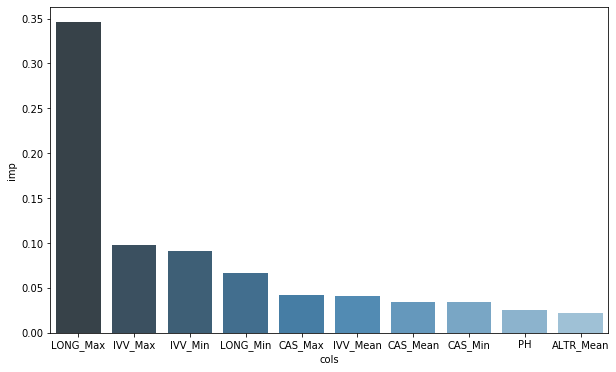

In [21]:
all_imp=feat_importance(pre_mod.feature_importances_,train_X,True)

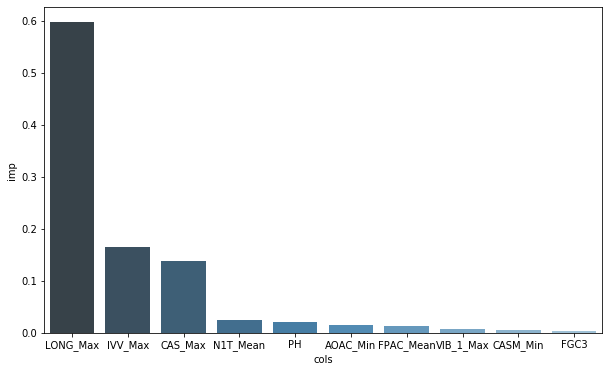

In [22]:
rf_cleaned_X = featcorr.betterval(all_imp,train_X)
cleaned_mod=RandomForestRegressor(n_estimators=25,min_samples_leaf=40)
cleaned_mod.fit(rf_cleaned_X[mask],train_y[mask])
rf_feat=feat_importance(cleaned_mod.feature_importances_,rf_cleaned_X,True)

<Figure size 504x288 with 0 Axes>

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


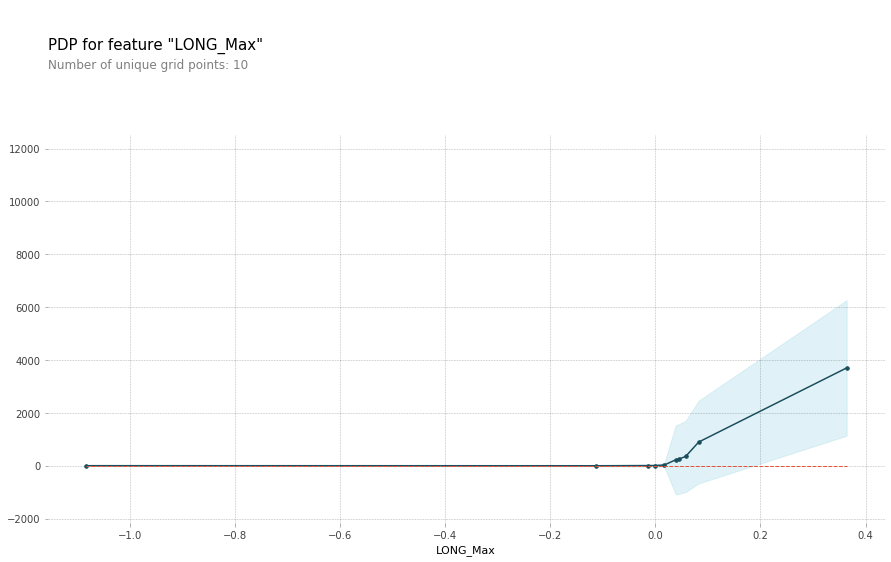

In [23]:
plt.figure(figsize=[7,4])
pdp_goals = pdp.pdp_isolate(model=cleaned_mod, dataset=rf_cleaned_X, model_features=rf_cleaned_X.columns, feature='LONG_Max')
pdp.pdp_plot(pdp_goals, 'LONG_Max')
plt.show()

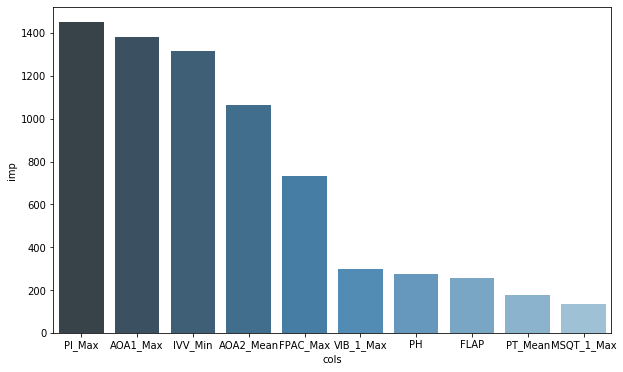

In [24]:
line_ppl=Pipeline(steps=[("reg",StandardScaler())
                    ,("model",LinearRegression())])
line_ppl.fit(train_X,train_y)

line_imp=feat_importance(line_ppl["model"].coef_, train_X)
line_cleaned_X = featcorr.betterval(line_imp,train_X)
line_ppl.fit(line_cleaned_X,train_y)
line_feat=feat_importance(line_ppl["model"].coef_, line_cleaned_X,True)

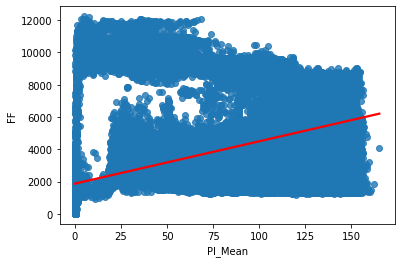

In [25]:
sns.regplot(x="PI_Mean",y="FF",data=train,line_kws={"color": "red"})

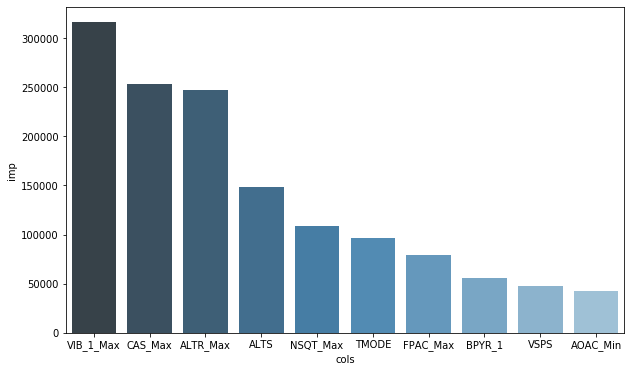

In [26]:
f_imp=feat_importance(f_regression(train_X,train_y)[0], train_X,False)
f_cleaned_X = featcorr.betterval(f_imp,train_X)
f_feat=feat_importance(f_regression(f_cleaned_X,train_y)[0], f_cleaned_X,True)

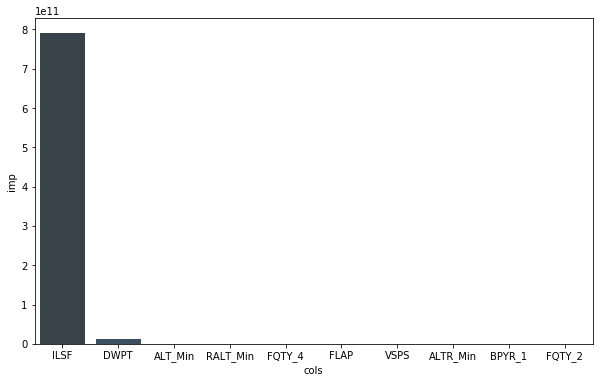

In [27]:
for_var = train_X.drop(columns="Flight_instance_ID")
var_imp=feat_importance(for_var.var().values, for_var)
var_cleaned_X = featcorr.betterval(var_imp,for_var)
var_feat=feat_importance(var_cleaned_X.var().values, var_cleaned_X,True)

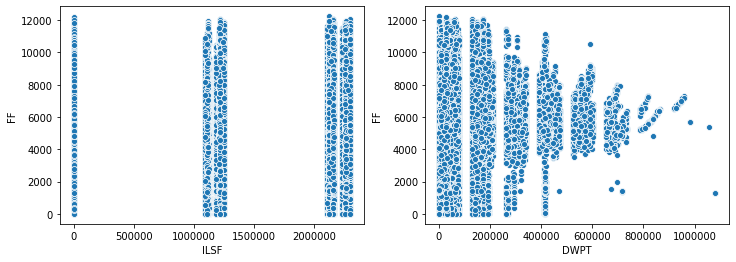

In [28]:
fig, axve = plt.subplots(1,2, figsize=(12, 4))
sns.scatterplot(x="ILSF",y="FF",data=train,ax=axve[0])
sns.scatterplot(x="DWPT",y="FF",data=train,ax=axve[1])
plt.show()

In [0]:
rf_col=rf_feat[:15].index.values
line_col=line_feat[:10].index.values
f_col=f_feat[:10].index.values
var_col=var_feat[:5].index.values
col_selec=np.unique(np.concatenate((rf_col,line_col,f_col,var_col)))
trainimp_X=train_X[col_selec]

In [30]:
col_selec.shape

(32,)

In [31]:
trainimp_X.head(5)

,ALTR_Max,ALTS,ALT_Min,AOA1_Max,AOA1_Mean,AOA2_Mean,AOAC_Min,BPYR_1,CASM_Min,CAS_Max,DWPT,FGC3,FLAP,FPAC_Max,FPAC_Mean,FQTY_4,ILSF,IVV_Max,IVV_Min,LONG_Max,LONG_Min,MSQT_1_Max,N1T_Mean,NSQT_Max,OIPL,PH,PI_Max,PT_Mean,RALT_Min,TMODE,VIB_1_Max,VSPS
598718,-1424.0,7000.0,7944.0,3.295875,3.098123,2.153305,2.592755,48.828247,300.0,211.3750,18576.0,26.0,94.0,0.025402,0.022837,3704.0,2157669.0,-1462.0,-1467.0,0.031252,0.030236,0.0,44.414062,1.0,15.0,6.0,74.28125,828.140625,5500.000,10.0,0.0625,-1504.0
635792,1488.0,30000.0,25879.0,-0.922843,-0.933829,-1.724837,-1.362296,58.593899,300.0,244.0000,402760.0,24.0,95.0,-0.004885,-0.004946,5504.0,1123429.0,1318.0,1317.0,0.093228,0.092720,0.0,94.171875,1.0,15.0,4.0,99.87500,461.437500,5500.000,8.0,0.1875,0.0
368739,-64.0,3000.0,656.0,5.844685,5.361290,-5.471152,0.000000,53.711075,300.0,0.0000,36.0,120.0,94.0,0.013678,0.007999,3688.0,2303397.0,1.0,-6.0,0.010932,0.000772,0.0,94.250000,0.0,15.0,2.0,0.93750,989.828125,-0.875,1.0,0.1250,-1312.0
469428,160.0,28000.0,28008.0,-3.295875,-3.361793,-3.669410,-3.559547,48.828247,287.0,274.9375,9248.0,24.0,94.0,-0.003908,-0.005007,5248.0,100.0,15.0,8.0,0.043444,0.040396,0.0,88.570312,1.0,15.0,5.0,127.96875,457.375000,5500.000,9.0,0.1250,-1008.0
684212,976.0,24000.0,19882.0,-2.460921,-2.625712,-3.537574,-3.207984,58.593899,300.0,280.6875,60556.0,24.0,94.0,0.009770,0.006473,7568.0,2270629.0,889.0,839.0,0.079004,0.077480,0.0,94.046875,1.0,15.0,4.0,133.50000,601.281250,5500.000,8.0,0.1250,0.0


#Outliers

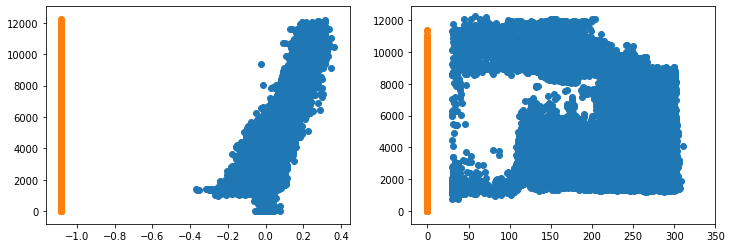

In [32]:
long_out=train_X["LONG_Max"]<-1
cas_out=train_X["CAS_Max"]<3
fig, axve = plt.subplots(1,2, figsize=(12, 4))
axve[0].scatter(train_X[~long_out]["LONG_Max"],train_y[~long_out])
axve[0].scatter(train_X[long_out]["LONG_Max"],train_y[long_out])
axve[1].scatter(train_X[~cas_out]["CAS_Max"],train_y[~cas_out])
axve[1].scatter(train_X[cas_out]["CAS_Max"],train_y[cas_out])
axve[1].set_xlim(-20,350)
plt.show()

In [0]:
others=compr(trainimp_X.columns,["LONG_Max","CAS_Max"])
ct = ColumnTransformer(transformers=[("simdt",MintoMean(0.01),["LONG_Max","CAS_Max"]),
                                     ("nother",DoNothing(),others)
                                     ],remainder="drop")
ppl=Pipeline(steps=[("main",ct)])

In [0]:
train_fin_X=ppl_to_df(ppl,"main",trainimp_X,train_y)

In [104]:
train_fin_X.head(5)

,LONG_Max,CAS_Max,LONG_Max_out,CAS_Max_out,ALTR_Max,ALTS,ALT_Min,AOA1_Max,AOA1_Mean,AOA2_Mean,AOAC_Min,BPYR_1,CASM_Min,DWPT,FGC3,FLAP,FPAC_Max,FPAC_Mean,FQTY_4,ILSF,IVV_Max,IVV_Min,LONG_Min,MSQT_1_Max,N1T_Mean,NSQT_Max,OIPL,PH,PI_Max,PT_Mean,RALT_Min,TMODE,VIB_1_Max,VSPS
0,0.031252,211.375000,0.0,0.0,-1424.0,7000.0,7944.0,3.295875,3.098123,2.153305,2.592755,48.828247,300.0,18576.0,26.0,94.0,0.025402,0.022837,3704.0,2157669.0,-1462.0,-1467.0,0.030236,0.0,44.414062,1.0,15.0,6.0,74.28125,828.140625,5500.000,10.0,0.0625,-1504.0
1,0.093228,244.000000,0.0,0.0,1488.0,30000.0,25879.0,-0.922843,-0.933829,-1.724837,-1.362296,58.593899,300.0,402760.0,24.0,95.0,-0.004885,-0.004946,5504.0,1123429.0,1318.0,1317.0,0.092720,0.0,94.171875,1.0,15.0,4.0,99.87500,461.437500,5500.000,8.0,0.1875,0.0
2,0.010932,254.757753,0.0,1.0,-64.0,3000.0,656.0,5.844685,5.361290,-5.471152,0.000000,53.711075,300.0,36.0,120.0,94.0,0.013678,0.007999,3688.0,2303397.0,1.0,-6.0,0.000772,0.0,94.250000,0.0,15.0,2.0,0.93750,989.828125,-0.875,1.0,0.1250,-1312.0
3,0.043444,274.937500,0.0,0.0,160.0,28000.0,28008.0,-3.295875,-3.361793,-3.669410,-3.559547,48.828247,287.0,9248.0,24.0,94.0,-0.003908,-0.005007,5248.0,100.0,15.0,8.0,0.040396,0.0,88.570312,1.0,15.0,5.0,127.96875,457.375000,5500.000,9.0,0.1250,-1008.0
4,0.079004,280.687500,0.0,0.0,976.0,24000.0,19882.0,-2.460921,-2.625712,-3.537574,-3.207984,58.593899,300.0,60556.0,24.0,94.0,0.009770,0.006473,7568.0,2270629.0,889.0,839.0,0.077480,0.0,94.046875,1.0,15.0,4.0,133.50000,601.281250,5500.000,8.0,0.1250,0.0


# Grid search

In [0]:
test_fin=ppl_to_df(ppl,"main",test_X,test_y,False)

In [107]:
searc_rf=RandomForestRegressor(n_estimators=20)
searc_rf.fit(train_fin_X[mask],train_y[mask])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [108]:
mean_squared_error(test_y,searc_rf.predict(test_fin))

48045.961604799995

In [0]:
xgb_model = XGBRegressor(n_estimators=10000, learning_rate=0.1, n_jobs=-1)

In [119]:
xgb_model.fit(train_fin_X, train_y, 
             early_stopping_rounds=5, 
             eval_set=[(test_fin, test_y)], 
             verbose=False)

[10:01:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=10000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [120]:
mean_squared_error(test_y,xgb_model.predict(test_fin))

53627.35673647811